<a href="https://colab.research.google.com/github/Alifiamutiaaa/UASMachineLearning/blob/main/UASML_TransferLearning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning
---

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [12]:
data_dir = '/content/gdrive/MyDrive/hymenoptera_data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

['ants', 'bees']


In [13]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [14]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

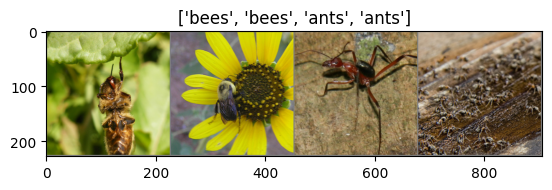

In [15]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


Epoch 0/24
----------
train Loss: 0.6473 Acc: 0.6557
val Loss: 0.4711 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.4979 Acc: 0.7828
val Loss: 0.3757 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4890 Acc: 0.7828
val Loss: 0.3085 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4247 Acc: 0.7992
val Loss: 0.2686 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4512 Acc: 0.7828
val Loss: 0.2345 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3429 Acc: 0.8730
val Loss: 0.2134 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4291 Acc: 0.7910
val Loss: 0.2073 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3472 Acc: 0.8361
val Loss: 0.2087 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3444 Acc: 0.8648
val Loss: 0.2035 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3622 Acc: 0.8607
val Loss: 0.2214 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3363 Acc: 0.8689
val Loss: 0.2178 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3077 Acc: 0.8811
val Loss: 0.2096 Acc: 0.9477

Ep

In [17]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5952 Acc: 0.6803
val Loss: 0.2014 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4976 Acc: 0.7746
val Loss: 0.1998 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.6553 Acc: 0.7336
val Loss: 0.1938 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5812 Acc: 0.7377
val Loss: 0.4546 Acc: 0.8039

Epoch 4/24
----------
train Loss: 0.4572 Acc: 0.7910
val Loss: 0.2102 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4492 Acc: 0.8033
val Loss: 0.1623 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5986 Acc: 0.7623
val Loss: 0.2821 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3820 Acc: 0.8361
val Loss: 0.2275 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3206 Acc: 0.8566
val Loss: 0.1883 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3627 Acc: 0.8443
val Loss: 0.1710 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3533 Acc: 0.8361
val Loss: 0.1744 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2605 Acc: 0.8934
val Loss: 0.2006 Acc: 0.9412

Ep